# Using ndio + OCP to Analyze Data
In this notebook, we'll see how easy it is to download and analyze data stored in OCP with the ndio Python library.

## Setup
First, let's include the ndio library. If you don't have it installed, you can download it using pip:

```
pip install ndio
```

We'll use three parts of ndio's functionality in this example: `ndio.remote` to download data from OCP (plus `ndio.utils` to ease this process), and `ndio.convert` to get the neuro data into a more user-friendly format.

In [1]:
import ndio.utils
import ndio.remote.OCP as OCP
import ndio.convert.hdf5, ndio.convert

We'll also use `numpy` to do some matrix manipulations:

In [2]:
import numpy

We now have everything we need to begin.

## Finding A Dataset
Let's take a look at all of the available, open-source, public-facing projects OCP stores. OCP accesses projects using *tokens*. More information about tokens is available [here](#).

We can use `ndio` to access the OCP API to list all public projects. Let's create a new `OCP` endpoint. We'll `ping` it to make sure we can access data from it, and then we'll ask it for all public tokens.

In [3]:
oo = OCP()
# 200 is the HTTP "Success" status code
"Everything's working!" if oo.ping() == 200 else "Bad! :("

"Everything's working!"

In [4]:
oo.get_public_tokens()

[u'ac3',
 u'ac4',
 u'bock11',
 u'cajal_demo',
 u'Ex10R55',
 u'Ex12R75',
 u'Ex12R76',
 u'Ex13R51',
 u'Ex14R58',
 u'Ex2R18C1',
 u'Ex2R18C2',
 u'Ex3R43C1',
 u'Ex3R43C2',
 u'Ex3R43C3',
 u'Ex6R15C1',
 u'Ex6R15C2',
 u'kasthuri11',
 u'kasthuri14Maine',
 u'kasthuri14s1colANNO',
 u'kasthuri14s1colEM',
 u'kat11greencylinder',
 u'kat11mito',
 u'kat11mojocylinder',
 u'kat11redcylinder',
 u'kat11segments',
 u'kat11synapses',
 u'kat11vesicles',
 u'mniatlas',
 u'test_ramonify_public']

## Rendering an Image from a `remote` Server
The `kasthuri14Maine` token contains image data from Dr. Bobby Kasthuri's [2015 CELL Paper](#). Let's take a look. We'll use `PIL` and `StringIO` to handle rendering the image.

> <small>**Note**: This isn't a very efficient way of downloading and showing data. If you want to render a larger dataset, consider using `ndio.remote.OCP.get_data()` instead.</small>

In [5]:
from PIL import Image
from StringIO import StringIO

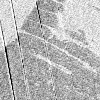

In [6]:
Image.open(StringIO(
        oo.get_image('kasthuri14Maine', 1200, 1300,
                                        1200, 1300,
                                        500, 1)))

*neato!*

## Downloading Annotation Data
The OCP framework differentiates between `image` data and `annotation` data, or *"paint"*. Annotations can represent anything; the `kat11mito` public token stores a binary matrix of `0` or `1`, with the `1` representing that this voxel is inside a mitochondrion.

Let's download a sample of this annotation data and run some stats.

First, we'll get the bounds of the data. We don't want to ask for data outside of the boundaries of the annotation matrix! We'll use `ndio` to get this information. The `ndio.remote.OCP.get_proj_info()` function returns JSON data; we can reference it like a regular Python dictionary:

In [7]:
json_data = oo.get_proj_info('kat11mito')
json_data['dataset']['imagesize']

{u'0': [21504, 26624, 1850],
 u'1': [10752, 13312, 1850],
 u'2': [5376, 6656, 1850],
 u'3': [2688, 3328, 1850],
 u'4': [1344, 1664, 1850],
 u'5': [672, 832, 1850],
 u'6': [336, 416, 1850],
 u'7': [168, 208, 1850]}

Each of these items holds the image size for a given resolution. All data is uploaded in `resolution = 0`. OCP can then down-sample this data to get more manageable-sized arrays. For our purposes, we can use `resolution = 3`. 

Let's use ndio to cut out a chunk of data from the `kat11mito` dataset:

> <small> **Note:** For some slower internet connections or computers, this command may take a very long time. </small>

In [8]:
"""
kat11mito = oo.get_cutout('kat11mito', 'annotation',
              x_start=694,  x_stop=1794,
              y_start=1750, y_stop=2460,
              z_start=1004, z_stop=1379, resolution=3)
"""
kat11mito = oo.get_cutout('kat11mito', 'annotation',
              x_start=1694, x_stop=1794,
              y_start=750,  y_stop=1000,
              z_start=1004, z_stop=1079, resolution=3)

We now have data stored in the `kat11mito` variable. Let's run some analytics!

### Counting Number of Populated Voxels
This is a good sanity check to be sure that you pulled down actual data and not just a ton of zeros: Let's count how many of our voxels contain non-zero data!

> <small> **Note:** For some slower computers, this command may take a very long time. It might be smart to run this in a `pypy` (or otherwise optimized) context.</small>

In [9]:
sum(sum(sum(kat11mito > 0)))

0